# MNIST Image Classification with TensorFlow

This notebook demonstrates how to implement a simple linear image models on MNIST using Estimator.
<hr/>
This <a href="mnist_models.ipynb">companion notebook</a> extends the basic harness of this notebook to a variety of models including DNN, CNN, dropout, pooling etc.

In [1]:
import numpy as np
import shutil
import os
import tensorflow as tf
print(tf.__version__)

/usr/local/envs/py3env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.8.0


In [ ]:
import numpy as np
import shutil
import os
import tensorflow as tf
print(tf.__version__)

## Exploring the data

Let's download MNIST data and examine the shape. We will need these numbers ...

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('mnist/data', one_hot=True, reshape=False)
print(mnist.train.images.shape)
print(mnist.train.labels.shape)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting mnist/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting mnist/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting mnist/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting mnist/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

In [ ]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('mnist/data', one_hot=True, reshape=False)
print(mnist.train.images.shape)
print(mnist.train.labels.shape)

In [3]:
HEIGHT=28
WIDTH=28
NCLASSES=10

In [ ]:
HEIGHT=28
WIDTH=28
NCLASSES=10

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


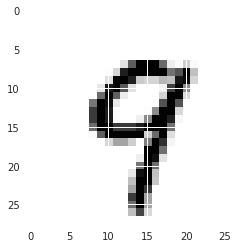

In [5]:
import matplotlib.pyplot as plt
IMGNO=12
plt.imshow(mnist.test.images[IMGNO].reshape(HEIGHT, WIDTH))

In [ ]:
import matplotlib.pyplot as plt
IMGNO=12
plt.imshow(mnist.test.images[IMGNO].reshape(HEIGHT, WIDTH));

## Define the model.
Let's start with a very simple linear classifier. All our models will have this basic interface -- they will take an image and return logits.

In [7]:
#Using low-level tensorflow
def linear_model(img):
  X = tf.reshape(img,[-1,HEIGHT*WIDTH]) #flatten
  W = tf.get_variable("W", [HEIGHT* WIDTH, NCLASSES],
                      initializer = tf.truncated_normal_initializer(stddev=0.1, seed=1)
                     )   
  b = tf.get_variable("b", NCLASSES, initializer=tf.zeros_initializer)
  ylogits=tf.malmul(X,W)+b
  return ylogits, NCLASSES

In [ ]:
#Using low-level tensorflow
def linear_model(img):
  X = tf.reshape(img,[-1,HEIGHT*WIDTH]) #flatten
  W = tf.get_variable("W", [HEIGHT*WIDTH,NCLASSES], 
                      initializer = tf.truncated_normal_initializer(stddev=0.1,seed = 1))
  b = tf.get_variable("b",NCLASSES, initializer = tf.zeros_initializer)
  ylogits = tf.matmul(X,W)+b
  return ylogits, NCLASSES

Note we can also build our linear classifer using the tf.layers API. Notice when using tf.layers we don't have to define or initialize our weights and biases. This happens automatically for us in the background.

When building more complex models such as DNNs and CNNs our code will be much more readable by using the tf.layers API

In [8]:
#Using tf.layers API
def linear_model(img):
  X = tf.reshape(img,[-1,HEIGHT*WIDTH]) #flatten
  ylogits = tf.layers.dense(X,NCLASSES,activation=None)
  return ylogits, NCLASSES

In [ ]:
#Using tf.layers API
def linear_model(img):
  X = tf.reshape(img,[-1,HEIGHT*WIDTH]) #flatten
  ylogits = tf.layers.dense(X,NCLASSES,activation=None)
  return ylogits, NCLASSES

## Write Input Functions

As usual, we need to specify input functions for training, evaluation, and predicition.

In [13]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
  x={'image':mnist.train.images},
  y=mnist.train.labels,
  batch_size=100,
  num_epochs=None,
  shuffle=True,
  queue_capacity=5000
)

eval_input_fn = tf.estimator.inputs.numpy_input_fn(
  x={'image':mnist.test.images},
  y=mnist.test.labels,
  batch_size=100,
  num_epochs=1,
  shuffle=True,
  queue_capacity=5000
)

def serving_input_fn():
  inputs = {'image': tf.placeholder(tf.float32, [None, HEIGHT, WIDTH])}
  features = inputs # as-is
  return tf.estimator.export.ServingInputReceiver(features,inputs)
  

In [ ]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'image':mnist.train.images},
    y=mnist.train.labels,
    batch_size=100,
    num_epochs=None,
    shuffle=True,
    queue_capacity=5000
  )

eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'image':mnist.test.images},
    y=mnist.test.labels,
    batch_size=100,
    num_epochs=1,
    shuffle=False,
    queue_capacity=5000
  )

def serving_input_fn():
    inputs = {'image': tf.placeholder(tf.float32, [None, HEIGHT, WIDTH])}
    features = inputs # as-is
    return tf.estimator.export.ServingInputReceiver(features, inputs)

## Write Custom Estimator
I could have simply used a canned LinearClassifier, but later on, I will want to use different models, and so let's write a custom estimator

In [22]:
def image_classifier(features, labels, mode, params):
  ylogits, nclasses = linear_model(features['image'])
  probabilities = tf.nn.softmax(ylogits)
  classes = tf.cast(tf.argmax(probabilities,1), tf.uint8)
  
  if mode == tf.estimator.ModeKeys.TRAIN or mode ==  tf.estimator.ModeKeys.EVAL:
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=ylogits, labels=labels))
    evalmetrics = {'accuracy': tf.metrics.accuracy(classes, tf.argmax(labels,1))}
    if mode == tf.estimator.ModeKeys.TRAIN:
      train_op = tf.contrib.layers.optimize_loss(loss, tf.train.get_global_step(),
                                                learning_rate=params['learning_rate'], optimizer='Adam')
    else:
      train_op = None
  else:
    loss = None
    train_op = None
    evalmetrics = None
  
  return tf.estimator.EstimatorSpec(
          mode=mode,
          predictions={'probabilities': probabilities, 'classes': classes},
          loss=loss,
          train_op=train_op,
          eval_metric_ops=evalmetrics,
          export_outputs={'classes':tf.estimator.export.PredictOutput({'probabilities': probabilities, 'classes': classes})}
  )

In [ ]:
def image_classifier(features, labels, mode, params):
  ylogits, nclasses = linear_model(features['image'])
  probabilities = tf.nn.softmax(ylogits)
  classes = tf.cast(tf.argmax(probabilities, 1), tf.uint8)
  
  if mode == tf.estimator.ModeKeys.TRAIN or mode == tf.estimator.ModeKeys.EVAL:
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=ylogits, labels=labels))
    evalmetrics =  {'accuracy': tf.metrics.accuracy(classes, tf.argmax(labels, 1))}
    if mode == tf.estimator.ModeKeys.TRAIN:
      train_op = tf.contrib.layers.optimize_loss(loss, tf.train.get_global_step(),
                                                 learning_rate=params['learning_rate'], optimizer="Adam")
    else:
      train_op = None
  else:
    loss = None
    train_op = None
    evalmetrics = None
 
  return tf.estimator.EstimatorSpec(
        mode=mode,
        predictions={"probabilities": probabilities, "classes": classes},
        loss=loss,
        train_op=train_op,
        eval_metric_ops=evalmetrics,
        export_outputs={'classes': tf.estimator.export.PredictOutput({"probabilities": probabilities, "classes": classes})}
    )

 tf.estimator.train_and_evaluate does distributed training.

In [19]:
def train_and_evaluate(output_dir, hparams):
  estimator = tf.estimator.Estimator(model_fn = image_classifier,
                                    params = hparams,
                                    model_dir = output_dir)
  train_spec = tf.estimator.TrainSpec(input_fn = train_input_fn,
                                     max_steps = hparams['train_steps'])
  exporter = tf.estimator.LatestExporter('Servo', serving_input_fn)
  eval_spec = tf.estimator.EvalSpec(input_fn = eval_input_fn, 
                                    steps = None,
                                    exporters = exporter)
  tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

In [ ]:
def train_and_evaluate(output_dir, hparams):
  estimator = tf.estimator.Estimator(model_fn = image_classifier,
                                     params = hparams,
                                     model_dir = output_dir)
  train_spec = tf.estimator.TrainSpec(input_fn = train_input_fn,
                                    max_steps = hparams['train_steps'])
  exporter = tf.estimator.LatestExporter('Servo', serving_input_fn)
  eval_spec = tf.estimator.EvalSpec(input_fn = eval_input_fn,
                                  steps = None,
                                  exporters = exporter)
  tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

This is the main() function

In [23]:
OUTDIR='mnist/learned'
shutil.rmtree(OUTDIR, ignore_errors=True) # start fresh each time

hparams ={'train_steps': 1000, 'learning_rate': 0.01}

train_and_evaluate(OUTDIR, hparams)


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_train_distribute': None, '_master': '', '_save_checkpoints_steps': None, '_num_ps_replicas': 0, '_task_type': 'worker', '_save_checkpoints_secs': 600, '_service': None, '_evaluation_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_is_chief': True, '_keep_checkpoint_max': 5, '_save_summary_steps': 100, '_model_dir': 'mnist/learned', '_log_step_count_steps': 100, '_session_config': None, '_global_id_in_cluster': 0, '_tf_random_seed': None, '_keep_checkpoint_every_n_hours': 10000, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f0c8184f2b0>}
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after 600 secs (eval_spec.throttle_secs) or training is finished.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorfl

In [ ]:
OUTDIR='mnist/learned'
shutil.rmtree(OUTDIR, ignore_errors = True) # start fresh each time

hparams = {'train_steps': 1000, 'learning_rate': 0.01}
train_and_evaluate(OUTDIR, hparams)

I got:

`Saving dict for global step 1000: accuracy = 0.9158, global_step = 1000, loss = 0.29720208`

In other words, we achieved 91.6% accuracy with the simple linear model!

<pre>
# Copyright 2017 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
</pre>